<div class="alert alert-block alert-info"> <b>NOTE:</b> This jupyter notebook is a companion to the <b>comparing_annotations.md</b> file. For more details read that documentation first and then come back here. </div>   
   
# BUSCO performance comparison
The code for the comparison uses a lot of files that won't be uploaded here. This is simply an **example** and a **documentation** of how to analize and plot BUSCO metrics for gene annotations from different sources/gene callers. This notebook just includes examples from plant species used for evaluation of Helixer and the final summary plot for all lineages. The plots are shown in a low resolution to keep the notebook file size smaller.  
   
The expected file structure the code is working with is as follows:

Each species folder is structured as follows (only files important for the analysis are mentioned):

## Parsing the data
Now that we know how the directories we will be using are structured, we can start with parsing the BUSCO output file `short_summary*.txt` for every gene caller, Helixer, AUGUSTUS and GeneMark, as well as the reference.

In [1]:
import re
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import numpy as np
import seaborn as sns

Example BUSCO summary:

In [2]:
path='../summary/plant/Arachis_hypogaea/busco/helixer_post/short_summary.specific.viridiplantae_odb10.tmp__prot.txt'
with open(path, 'r') as f:
    for line in f.readlines():
        print(line, end='')

# BUSCO version is: 5.2.2 
# The lineage dataset is: viridiplantae_odb10 (Creation date: 2020-09-10, number of genomes: 57, number of BUSCOs: 425)
# Summarized benchmarking in BUSCO notation for file /gpfs/project/alden101/ProjectsRoot/Ankylosaurus/unorganized/aardonyx/tf_tester/helixer/data/plants/single_testers/Arachis_hypogaea/meta_collection/helixer_post_v0.3_a_0080/protein.fa
# BUSCO was run in mode: proteins

	***** Results: *****

	C:99.3%[S:4.5%,D:94.8%],F:0.7%,M:0.0%,n:425	   
	422	Complete BUSCOs (C)			   
	19	Complete and single-copy BUSCOs (S)	   
	403	Complete and duplicated BUSCOs (D)	   
	3	Fragmented BUSCOs (F)			   
	0	Missing BUSCOs (M)			   
	425	Total BUSCO groups searched		   

Dependencies and versions:
	hmmsearch: 3.3


In [3]:
def parse_busco(path):
    raw = []
    with open(path) as f:
        for line in f:
            line = line.rstrip().strip()  # remove trailing characters (e.g newline) and whitespaces
            if re.match(r'^\d', line):  # check if line starts with a number, i.e. the table with complete, missing, ... BUSCO counts
                line = re.sub(' ', '_', line)  # replace spaces with underscore: Complete BUSCOs (C) -> Complete_BUSCOs_(C)
                sline = line.split()  # split line in count and category
                raw.append([int(sline[0]), sline[1]])
    # create pandas dataframe
    df = pd.DataFrame(raw)
    total = df.iloc[-1, 0]
    df.columns = ['count', 'category']
    df["fraction"] = df["count"] / total  # calculate fractions
    df.index = [re.sub('_BUSCO.*', '', x) for x in df["category"]]  # create row names
    return df

In [4]:
df = parse_busco(path)
df

,count,category,fraction
Complete,422,Complete_BUSCOs_(C),0.992941
Complete_and_single-copy,19,Complete_and_single-copy_BUSCOs_(S),0.044706
Complete_and_duplicated,403,Complete_and_duplicated_BUSCOs_(D),0.948235
Fragmented,3,Fragmented_BUSCOs_(F),0.007059
Missing,0,Missing_BUSCOs_(M),0.000000
Total,425,Total_BUSCO_groups_searched,1.000000


We import BUSCO short summary text files from every species in the given base directory (i.e. plant, fungi, vertebrate or invertebrate) and for every species every available "method" (i.e. reference, helixer_post, genemark, augustus).

In [5]:
# import buscos for all species
def import_full_species(basedir):
    dfs = {}
    for species in os.listdir(basedir):
        dfs[species] = {}
        try:
            for method in os.listdir(os.path.join(basedir, species, 'busco')):
                dfs[species][method] = {}
                paths = glob.glob(f'{basedir}/{species}/busco/{method}/short_summary*txt')
                assert len(paths) == 1
                dfs[species][method] = parse_busco(paths[0])
        except FileNotFoundError:
            pass
    return dfs

In [6]:
group = 'plant'
dfs = import_full_species(f'../summary/{group}/')

The fraction of complete and missing BUSCOs can now be extracted from the directories for every species and method (if available).

In [7]:
def extract1(df_dict, idx, colidx):
    # extract specific row and column from each busco dataframe created by import_full_species
    def thing_or_none(species, method):
        # check if busco values are available for selected species and method, if not return None
        try:
            out = df_dict[species][method].loc[idx, colidx]
        except KeyError:
            out = None
        return out
            
    methods = ['reference', 'helixer_post', 'genemark', 'augustus']
    lists = [[ thing_or_none(species, method) for method in methods] \
             for species in df_dict]
    df = pd.DataFrame(lists)
    df.index = [species for species in df_dict]  # row names = species
    df.columns = methods  # column names = methods
    return df

In [8]:
bcomp = extract1(dfs, 'Complete', 'fraction')
bmissing = extract1(dfs, 'Missing', 'fraction')
bcomp

,reference,helixer_post,genemark,augustus
Solanum_pennellii,0.995294,0.978824,0.743529,0.868235
Hibiscus_syriacus,0.964706,0.962353,0.931765,NaN
Brassica_napus,0.997647,0.997647,0.995294,NaN
Triticum_dicoccoides,0.990588,0.992941,0.093723,0.736471
Papaver_somniferum,1.000000,0.997647,0.851765,NaN
Vitis_riparia,0.995294,0.952941,0.687059,NaN
Nicotiana_attenuata,0.997647,0.971765,0.296471,0.844706
Setaria_viridis,0.995294,0.995294,0.131765,NaN
Oryza_brachyantha,0.997647,0.997647,0.098824,0.720000
Arachis_hypogaea,1.000000,0.992941,0.738824,NaN


## Plots
Next, we can plot heatmaps of the complete and missing BUSCOs. The plant species will be sorted the same way as the BUSCO summary figure of all lineages at the end of the notebook.

In [9]:
def heatmap(df, group, sort_order, lab="genic F1", cmap="viridis", dpi=200, figsize=(4,5), fsize=10):
    # sort dataframe according to the sort order
    df_reorder = df.loc[sort_order, :]
    # replace column and row name underscores with spaces
    df_reorder = df_reorder.rename(columns={'helixer_post': 'helixer post'},
                                   index={i:i.replace("_", " ") for i in df.index})
    
    

    # main plot
    # -----------
    sns.set_theme(rc={'figure.dpi': dpi})
    sns.set_style("dark")  # options: white, dark, whitegrid, darkgrid, ticks (heatmap background/missing data values)
    cg = sns.clustermap(df_reorder.iloc[:,:4], cmap=cmap, vmin=0, vmax=1,
                        cbar_kws={'label': lab, 'fraction': 0.07},
                        row_cluster=False, col_cluster=False,
                        figsize=figsize, cbar_pos=(0.6, 0.35, 0.05, 0.3))
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = fsize, style='italic')
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = fsize)
    plt.tick_params(labelsize=fsize)
    cg.ax_cbar.set_ylabel(lab,size=fsize)

In [10]:
# sort order extracted from the summary plot below to have a consitent sort order between all plots 
busco_ref_sort_plant = ['Papaver_somniferum', 'Arachis_hypogaea', 'Brassica_napus',
       'Oryza_brachyantha', 'Nicotiana_attenuata', 'Solanum_pennellii',
       'Setaria_viridis', 'Vitis_riparia', 'Triticum_dicoccoides',
       'Phoenix_dactylifera', 'Coffea_arabica', 'Cannabis_sativa',
       'Hibiscus_syriacus']

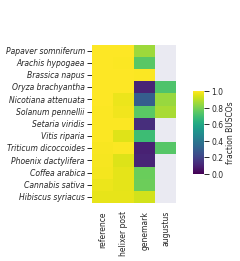

In [11]:
heatmap(bcomp, group, busco_ref_sort_plant, lab='fraction BUSCOs', dpi=55)

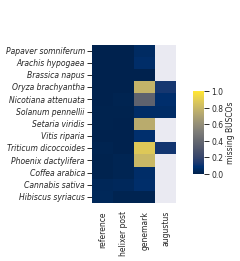

In [12]:
heatmap(bmissing, group, busco_ref_sort_plant, lab='missing BUSCOs', cmap='cividis', dpi=55)

Finally, we plot a summary clustermap of all BUSCO scores for every lineage. For that, we collect all BUSCO scores from every species. Here, as an example, we collected the fraction of complete BUSCOs for every species and lineage (group).

In [13]:
# all complete and missing BUSCOs example
bcomps = pd.concat([pd.concat([extract1(import_full_species(f'../summary/{group}/'), 'Complete', 'fraction'), ])
                    for group in ['fungi', 'plant', 'vertebrate', 'invertebrate']])

Now, we can create a function that collects the desired scores from a base directory, adds for each species the information to which group it belongs to and sorts the dataframe by group and inside the groups by the highest reference annotation BUSCO score.

In [14]:
def create_all_species_df(basedir, idx, colidx, group_names):
    # extract BUSCO scores for every species and group
    df = pd.concat([pd.concat([extract1(import_full_species(f'{basedir}/{group}/'), idx, colidx), ])
                    for group in group_names])
    
    # create lineage/group info array
    groups = np.concatenate([[group]*len(os.listdir(f'{basedir}/{group}/')) for group in group_names])
    
    # add group info for each species to the dataframe
    df['group'] = groups
    df = pd.DataFrame(df)

    # reorder the df to fungi, plants, vertebrates, invertebrates
    uniques = np.unique(df['group'], return_counts=True, return_index=True)
    uniques = [x[[0, 2, 3, 1]] for x in uniques]
    ylabs, start, lengths = uniques

    # sort by reference best reference annotation BUSCO score inside each group
    # (best BUSCO reference score at the top of each group)
    df = pd.concat([
        df.iloc[i:i + count, :].sort_values(by='reference', ascending=False) for i, count in zip(start, lengths)
    ])
    return df

In [15]:
bcomps = create_all_species_df('../summary', idx='Complete', colidx='fraction',
                               group_names=['fungi', 'plant', 'vertebrate', 'invertebrate'])

In [16]:
# difference helixer to reference
(bcomps['reference'] - bcomps['helixer_post']).describe()

count    45.000000
mean      0.036482
std       0.084337
min      -0.067282
25%       0.002353
50%       0.023529
75%       0.036688
max       0.468553
dtype: float64

In [17]:
bmissing = create_all_species_df('../summary', idx='Missing', colidx='fraction',
                                 group_names=['fungi', 'plant', 'vertebrate', 'invertebrate'])

In [18]:
def plot_busco_summary(all_df, figsize=(2.5,4.5), dpi=100, fsize=10, lab='fraction BUSCOs', cmap='viridis', figname='filler'):
    df_reorder = all_df.rename(columns={'helixer_post': 'helixer post'})
    
    # colors
    cmap2=plt.get_cmap("Set1") 
    x = [8, 1, 0, 2]  # 2=green, 8=grey, 0=red, 1=blue
    colors = np.array(cmap2.colors)[np.array(x)]
    
    # order colors to match 
    key={'invertebrate': 0, 'vertebrate': 2, 'fungi': 1, 'plant': 3}
    newc = [colors[key[x]] for x in df_reorder['group']]
    
    # main plot
    # -----------
    sns.set_theme(rc={'figure.dpi': dpi})
    sns.set_style("dark")  # options: white, dark, whitegrid, darkgrid, ticks (heatmap background/missing data values)
    cg = sns.clustermap(df_reorder.iloc[:,:4], cmap=cmap, vmin=0, vmax=1,
                        cbar_kws={'label': lab, 'fraction': 0.07},
                        row_cluster=False, yticklabels=False, col_cluster=False, row_colors=newc,
                        figsize=figsize, cbar_pos=(1, 0.35, 0.1, 0.3), 
                        colors_ratio=0.07)
    
    ylabs, start, lengths = np.unique(df_reorder['group'], return_counts=True, return_index=True)
    
    cg.ax_row_colors.set_yticks(start + lengths // 2)
    cg.ax_row_colors.set_yticklabels(ylabs, rotation=60, size=fsize)
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = fsize)
    plt.tick_params(labelsize=fsize)
    cg.ax_cbar.set_ylabel(lab,size=fsize)

    # save figure
    #cg.savefig(f"joint/{figname}.pdf")
    #cg.savefig(f"joint/{figname}.eps")

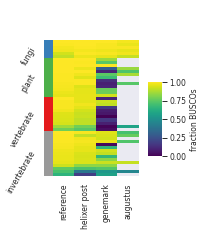

In [19]:
plot_busco_summary(bcomps, dpi=55)

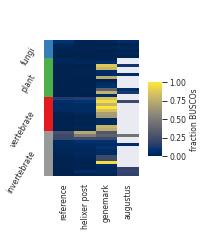

In [20]:
plot_busco_summary(bmissing, dpi=55, cmap='cividis')

In [21]:
# passed to all other heat- and clustermaps, to maintain order
# (see vs_reference_performance_comparison.ipynb and vs_reference_performance_gffcompare.ipynb)
bcomps.index

Index(['Neurospora_crassa', 'Coccidioides_immitis', 'Fusarium_graminearum',
       'Debaryomyces_hansenii', 'Aspergillus_terreus', 'Laccaria_bicolor',
       'Papaver_somniferum', 'Arachis_hypogaea', 'Brassica_napus',
       'Nicotiana_attenuata', 'Oryza_brachyantha', 'Solanum_pennellii',
       'Vitis_riparia', 'Setaria_viridis', 'Triticum_dicoccoides',
       'Phoenix_dactylifera', 'Coffea_arabica', 'Cannabis_sativa',
       'Hibiscus_syriacus', 'Balaenoptera_musculus', 'Sparus_aurata',
       'Xiphias_gladius', 'Desmodus_rotundus', 'Pseudonaja_textilis',
       'Falco_naumanni', 'Chiroxiphia_lanceolata', 'Myotis_davidii',
       'Lagopus_leucura', 'Rhincodon_typus', 'Opisthocomus_hoazin',
       'Bombus_impatiens', 'Tribolium_castaneum', 'Drosophila_virilis',
       'Apis_dorsata', 'Frankliniella_occidentalis', 'Trachymyrmex_cornetzi',
       'Drosophila_albomicans', 'Ctenocephalides_felis', 'Atta_cephalotes',
       'Rhopalosiphum_maidis', 'Culex_pipiens', 'Hyposmocoma_kahamanoa',


In [22]:
# save BUSCO scores dataframe as csv
bcomps.rename(columns={'helixer_post': 'helixer post'})
bcomps.to_csv('joint/fraction_BUSCOs.csv')